In [52]:
from PyQSPICE import clsQSPICE as pqs

import re
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseEvent
from matplotlib.widgets import RangeSlider

fname = "VerilogBus"

run = pqs(fname)

run.InitPlot()

run.qsch2cir()
run.cir2qraw()

run.setNline(499)

#df = run.LoadQRAW(["V(outD[3])", "V(outD[2])", "V(outD[1])", "V(outD[0])", "V(outA)"])
dfA = run.LoadQRAW(["V(outA)"])
dfD = run.LoadQRAW(["V(outD[3])", "V(outD[2])", "V(outD[1])", "V(outD[0])"])

df = pd.merge(dfA, dfD)

df['busVal'] = df['V(outD[0])'] * 1 + df['V(outD[1])'] * 2 + df['V(outD[2])'] * 4 + df['V(outD[3])'] * 8
df["flg"] = df.diff().loc[:,"busVal"].fillna(0)

dfl = df[df.flg != 0]
busVal = df.busVal

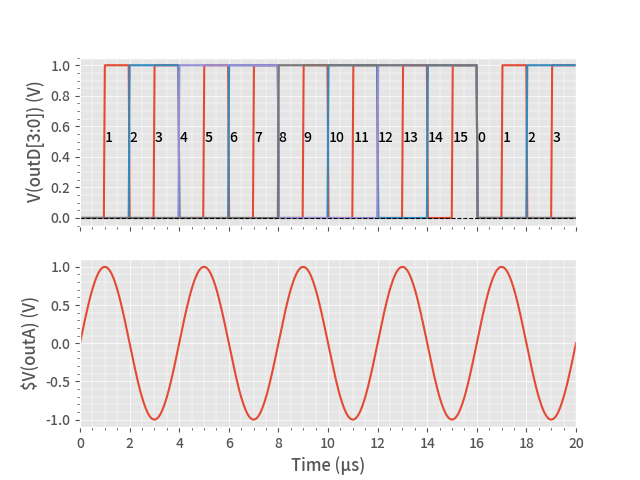

In [53]:
%matplotlib ipympl

plt.close('all')
# Prepare a blank plotting area
fig, (axT, axB) = plt.subplots(2,1,sharex=True)

# Plot TRAN waveforms
for i in range(4):
    df.plot(ax=axT, x="Time",  y="V(outD[" + str(i) + "])", label="V(outD[" + str(i) + "])")
df.plot(ax=axB, x="Time",  y="V(outA)", label="V(oanA)")

axB.get_legend().remove()
axT.get_legend().remove()

run.PrepTimePlot(axT, "Time", r"V(outD[3:0]) (V)", [0, 20e-6], "auto")
run.PrepTimePlot(axB, "Time", r"$V(outA) (V)", [0, 20e-6], "auto")

for idx, row in dfl.iterrows():
    axT.text(row["Time"], 0.5, f'{int(row["busVal"]):d}')

# Save the PLot in PNG file

from matplotlib.backend_bases import MouseEvent

class SnappingCursor:
    def __init__(self, ax, line):
        self.ax = ax
        self.horizontal_line = ax.axhline(color='k', lw=0.8, ls='--')
        self.vertical_line = ax.axvline(color='k', lw=0.8, ls='--')
        self.x, self.y = line.get_data()
        self._last_index = None
        # text location in axes coords
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes)

    def set_cross_hair_visible(self, visible):
        need_redraw = self.horizontal_line.get_visible() != visible
        self.horizontal_line.set_visible(visible)
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def on_mouse_move(self, event):
        if not event.inaxes:
            self._last_index = None
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            index = min(np.searchsorted(self.x, x), len(self.x) - 1)
            if index == self._last_index:
                return  # still on the same data point. Nothing to do.
            self._last_index = index
            x = self.x[index]
            y = busVal[index]
            # update the line positions
            self.horizontal_line.set_ydata([y])
            self.vertical_line.set_xdata([x])
            self.text.set_text(f'x={x:1.2e}, y={int(y):1d}')
            self.ax.figure.canvas.draw()

#slider_ax = fig.add_axes([0.1, 0.05, 0.8, 0.03])
#xarr, yarr = axB.lines[0].get_data()
#slider = RangeSlider(slider_ax, "", xarr.min(), xarr.max(), valfmt="")

#lower_limit_line = axB.axvline(slider.val[0], color='k')
#upper_limit_line = axB.axvline(slider.val[1], color='k')

def update(val):
    lower_limit_line.set_xdata([val[0], val[0]])
    upper_limit_line.set_xdata([val[1], val[1]])

    fig.canvas.draw_idle()

#slider.on_changed(update)

snap_cursor = SnappingCursor(axT, axT.lines[0])
fig.canvas.mpl_connect('motion_notify_event', snap_cursor.on_mouse_move)

# Simulate a mouse move to (0.5, 0.5), needed for online docs
#t = axB.transData
#MouseEvent(
#    "motion_notify_event", axB.figure.canvas, *t.transform((2e-6, 0.1))
#)._process()

plt.show()